
# Project: Investigate a Dataset (TMDb Movie Data)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

Dataset link: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata

The data set used for this analysis is a TMDb's data set which contains information (such as; ratings, revenue etc.) on 10,866 movies spanning from 1960 to 2015. 

### Question(s) for Analysis
    1. Which movie has the highest and lowest budget?
    2. Which movie has the highest and lowest revenue?
    3. Which year has the highest revenue?
    4. Which genre has the highest revenue?
    5. Which genre is most popular?
    6. Which genre has the best rating?
    7. What genre is most successful?
    


In [5]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

  Using cached https://files.pythonhosted.org/packages/1d/9a/7eb9952f4b4d73fbd75ad1d5d6112f407e695957444cb695cbb3cdab918a/pandas-0.25.0-cp36-cp36m-manylinux1_x86_64.whl


Packages importation

In [1]:
#import packages needed for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

#Display visuals in the notebook
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

Here, we'll load the data and view it to get a genral overview. Then check for missing values and duplicates and we'll drop columns that are not of significant importance to the analysis.

In [2]:
# Load the csv file using pandas and print out a few lines. 
df_M = pd.read_csv('tmdb_movies.csv')
df_M.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [3]:
#To see the number of observations and columns
print('There are', df_M.shape[0], 'observations and', df_M.shape[1], 'columns.')

There are 10866 observations and 21 columns.


In [4]:
#to see the column information, check if there are null values present and also see the data types present.
df_M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

From the output above, there are a total of 10866 observations and 21 columns. We observe some null values in some of the columns present and there are some columns also that are not significant to this analysis. So, we'll drop the columns we won't be using and also drop null values in the dataset.

In [5]:
#dropping columns not needed
df_M.drop(['id', 'homepage', 'tagline', 'release_date', 'imdb_id', 'overview', 'cast', 'director', 'keywords', 'production_companies', 'budget_adj', 'revenue_adj'], axis = 1, inplace = True)

Checking for null values in the new data set

In [6]:
df_M.isnull().sum()

popularity         0
budget             0
revenue            0
original_title     0
runtime            0
genres            23
vote_count         0
vote_average       0
release_year       0
dtype: int64

So, we have 23 null values in the genre column. I'll go ahead and drop this null values and proceed from there.

In [7]:
df_M.dropna(subset = ['genres'], inplace =True)

Let's confirm we no longer have missing values.

In [8]:
df_M.isnull().sum()

popularity        0
budget            0
revenue           0
original_title    0
runtime           0
genres            0
vote_count        0
vote_average      0
release_year      0
dtype: int64

We no longer have missing value in our data set. Let's look at the data to see if the changes has been effected.

In [9]:
df_M.head(3)

,popularity,budget,revenue,original_title,runtime,genres,vote_count,vote_average,release_year
0,32.985763,150000000,1513528810,Jurassic World,124,Action|Adventure|Science Fiction|Thriller,5562,6.5,2015
1,28.419936,150000000,378436354,Mad Max: Fury Road,120,Action|Adventure|Science Fiction|Thriller,6185,7.1,2015
2,13.112507,110000000,295238201,Insurgent,119,Adventure|Science Fiction|Thriller,2480,6.3,2015


Taking another look at the data, we discover that the column tagged 'genres' are separated by '|'. We will use the split function to separate this genres and create a new entry for each genre a movie falls into

In [10]:
#rename the original data
df_MO = df_M

In [11]:
#split columns by "|"
df_MO['genres'] = df_M['genres'].apply(lambda x: x.split("|")[0])

In [12]:
#check if the columns are splitted 
df_MO.genres.unique()

array(['Action', 'Adventure', 'Western', 'Science Fiction', 'Drama',
       'Family', 'Comedy', 'Crime', 'Romance', 'War', 'Mystery',
       'Thriller', 'Fantasy', 'History', 'Animation', 'Horror', 'Music',
       'Documentary', 'TV Movie', 'Foreign'], dtype=object)

In [13]:
#we check for duplicates
df_MO.duplicated().sum()

1

In [14]:
#Here we drop the duplicate 
df_MO.drop_duplicates(inplace = True)

In [15]:
df_MO.shape

(10842, 9)

Now, we have 10,842 observations and 9 columns. The data is ready for exploratory analysis.

<a id='eda'></a>
## Exploratory Data Analysis


### Question 1: Which movie has the highest and lowest budget?

In [16]:
#here, we use the function 'idmin' to find the index of lowest and 'idmax' to find the index of highest.

def find_minmax(x):
    min_index = df_MO[x].idxmin()
    high_index = df_MO[x].idxmax()
    high = pd.DataFrame(df_MO.loc[high_index,:])
    low = pd.DataFrame(df_MO.loc[min_index,:])
    
    #print the movie with highest and lowest 
    print("Movie with the highest "+ x + " : ",df_MO['original_title'][high_index])
    print("Movie with the lowest "+ x + "  : ",df_MO['original_title'][min_index])
    return pd.concat([high,low],axis = 1)

In [17]:
df_MO['budget'] = df_MO['budget'].replace(0,np.NAN)
find_minmax('budget')

Movie with the highest budget :  The Warrior's Way
Movie with the lowest budget  :  Fear Clinic


,2244,1151
popularity,0.25054,0.177102
budget,4.25e+08,1
revenue,11087569,0
original_title,The Warrior's Way,Fear Clinic
runtime,100,95
genres,Adventure,Horror
vote_count,74,15
vote_average,6.4,4.1
release_year,2010,2014


### Question 2: Which movie has the highest and lowest revenue?

In [18]:
df_MO['revenue'] = df_MO['revenue'].replace(0,np.NAN)
find_minmax('revenue')

Movie with the highest revenue :  Avatar
Movie with the lowest revenue  :  Shattered Glass


,1386,5067
popularity,9.43277,0.462609
budget,2.37e+08,6e+06
revenue,2.78151e+09,2
original_title,Avatar,Shattered Glass
runtime,162,94
genres,Action,Drama
vote_count,8458,46
vote_average,7.1,6.4
release_year,2009,2003


Observation: From the results above, "The warrior's way" is the movie with the highest budget but it's not the movie that returns the highest revenue. This tells us that a high budget does not necessarily means a high return of revenue.

### Research Question 3:  Which year has the highest revenue?

To see the trend of revenue from year to year, we plot a line graph of revenue and the years.

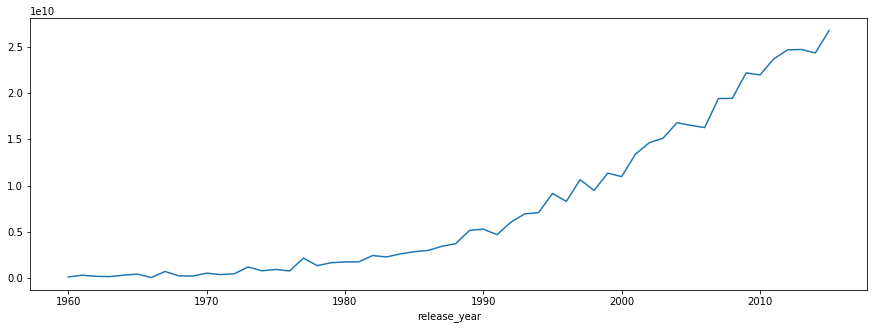

In [19]:
# plot a line graph of year and revenue
df_MO.groupby('release_year')['revenue'].sum().plot(kind = 'line', figsize = (15,5));


From the graph, we observe that movie revenue increases as the year increases with the most recent year having the highest revenue.

### Research Question 4: Which genres has the highest revenue?

Here, we want to determine which genre has the higest revenue.

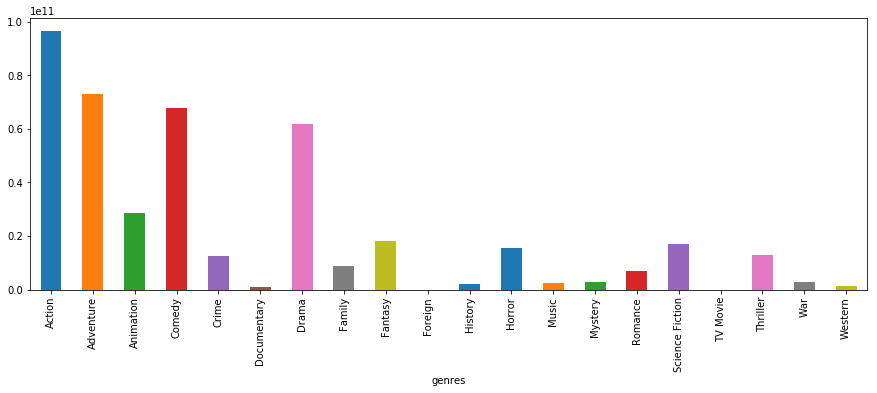

In [20]:
#plot a bar chart of genres against revenue
df_MO.groupby('genres')['revenue'].sum().plot(kind = 'bar', figsize = (15,5));

From the output, we observe that the genre "action" has the highest number of movie whose revenue are high. "adventure", "comedy", and "drama" are the other genres with high revenue.

### Research Question 5: Which genre is most popular?

To determine the genre that's most popular, we plot a bar chart of 'genres' against 'popularity'

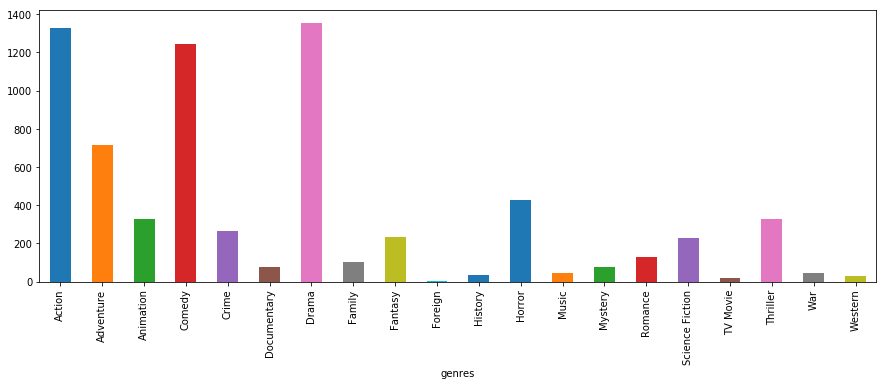

In [21]:
df_MO.groupby('genres')['popularity'].sum().plot(kind = 'bar', figsize = (15,5));

### Research Question 6: Which genre has the best rating?

Here, we are looking to determine the genre with the best rating 

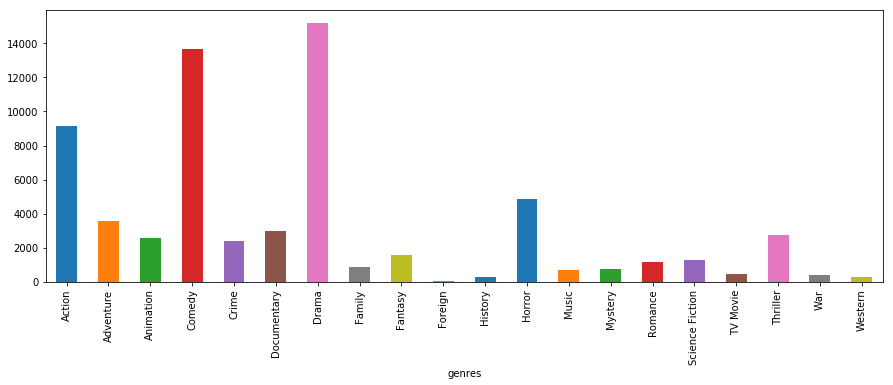

In [22]:
df_MO.groupby('genres')['vote_average'].sum().plot(kind = 'bar', figsize = (15,5));

### Research Question 7: What genre is most successful?

First, let's find out which genre is mostsly produced.

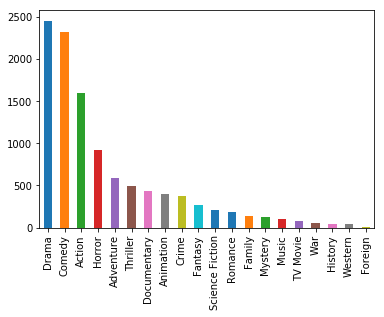

In [23]:
df_MO['genres'].value_counts().plot(kind='bar');

From the chart above, we can see that Drama and Comedy are the most produced movies.

So, how do we determine if a movie is successful. A movie is said to be successful if its revenue is twice its budget.

To proceed, we would need to create a column that multiplies the budget by 2 which we would label "budget_x2". Then to determine the if the movie is successful, we'd create another column labelled "successful", and a code that returns 'True' if the 'revenue' is greater than or equal to 'budget_x2', otherwise it returns 'False'. 

In [24]:
# This function creates a new column that has each row of the column 'budget' multiplied by 2
results = []

for i, row in df_MO.iterrows():
    result = (row['budget']*2)
    results.append(result)
    
df_MO['budget_x2'] = results  

In [25]:
#This creates a new column that returns true if a movie is successful and false if not 

df_MO['success'] = np.where(df_MO['revenue'] >= df_MO['budget_x2'], 'Successful', 'Unsuccessful')

In [26]:
df_MO_success = df_MO.groupby(['genres', 'success']).count()['popularity'].unstack()

In [27]:
df_MO_success.head(20)

success,Successful,Unsuccessful
genres,,
Action,330.0,1260.0
Adventure,176.0,410.0
Animation,64.0,339.0
Comedy,442.0,1877.0
Crime,86.0,294.0
Documentary,21.0,411.0
Drama,419.0,2034.0
Family,23.0,121.0
Fantasy,61.0,211.0


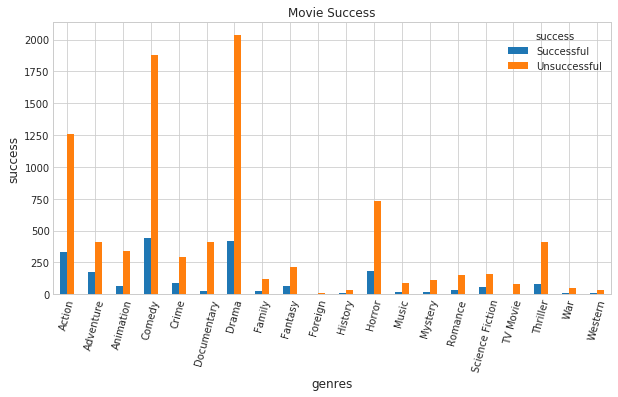

In [31]:
#We plot a bar chart to display genres and their success rate.
df_MO_success.plot(kind = 'bar', figsize=(10,5))

plt.title("Movie Success",fontsize=12)
plt.xticks(rotation=75)
plt.xlabel("genres",fontsize= 12)
plt.ylabel("success",fontsize= 12)
sns.set_style("whitegrid")

Observation;

Although, we have more movies that are "unsuccessful", we observe that in terms of successful genres, "Comedy" is the most successful genre followed by "Drama". We can then infer from this that the success recorded in these genres is the reason for their high production.

# <a id='conclusions'></a>
## Conclusions

> **1**: The movie with the highest budget isn't the movie with the highest revenue which implies that a high budget doesn't necessarily imply a high return of revenue. 

> **2**: The revenue for each genre increases from year to year with the most recent year having the highest revenue.  

> **3**: Drama is a genre that's most popular and has the highest ratings. This also most likely are reasons its the most produceds  genres of movies. 

> **4**: Although, we have more unsuccessful movies which are a result of different factors, the genre "drama" is the most successful movies according to the standard that "a successful movie is one which returns twice its budget". This is also further attributes to why it is the most produced genre. 

Resources

https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
https://www.kaggle.com/code/lorenzhering/movie-data-analysis/notebook
https://github.com/onpillow/Udacity-DAND-Term1/blob/master/p2/Investigate_a_Dataset.ipynb
https://www.kaggle.com/code/deepak525/investigate-tmdb-movie-dataset/notebook
https://datascienceparichay.com/article/pandas-create-column-based-on-condition/
https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/

In [32]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0

In [ ]:
21